# Access AWS CESM2 using the AWS open data origin data and benchmark

In [27]:
# Display output of plots directly in Notebook
import intake
import numpy as np
import pandas as pd
import xarray as xr
import re
import aiohttp
import time
from contextlib import contextmanager
import matplotlib.pyplot as plt

In [28]:
import fsspec.implementations.http as fshttp
from pelicanfs.core import PelicanFileSystem, PelicanMap, OSDFFileSystem 

In [29]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [30]:
init_year0  = '1991'
init_year1  = '2020'
final_year0 = '2071'
final_year1 = '2100'

In [31]:
# # This overwrites the default scheduler with a single-threaded scheduler
# dask.config.set(scheduler='synchronous')  

In [32]:
# File paths
rda_scratch   = '/gpfs/csfs1/collections/rda/scratch/harshah'
rda_url       =  'https://data.rda.ucar.edu/'
database_num  = 'd345001'
cam6_dart_url = rda_url + database_num
#
https_catalog = cam6_dart_url + '/catalogs/https/'+ database_num +'-https-zarr.json'
osdf_catalog  = cam6_dart_url + '/catalogs/osdf/'+ database_num +'-osdf-zarr.json'

## Open intake catalog and load files after spinning up a cluster

In [33]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '4GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    resource_spec = 'select=1:ncpus=1:mem=4GB',
    queue = 'casper',
    walltime = '5:00:00',
    log_directory = rda_scratch+'/dask/logs',
    #interface = 'ib0'
    interface = 'ext'
)

/glade/work/harshah/conda-envs/arco_experiments/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33797 instead
  warnings.warn(
2024-11-07 09:55:31,695 - distributed.deploy.cluster - ERROR - 'tcp://128.117.208.112:42481'
Traceback (most recent call last):
  File "/glade/work/harshah/conda-envs/arco_experiments/lib/python3.12/site-packages/distributed/deploy/cluster.py", line 245, in _watch_worker_status
    self._update_worker_status(op, msg)
  File "/glade/work/harshah/conda-envs/arco_experiments/lib/python3.12/site-packages/distributed/deploy/spec.py", line 394, in _update_worker_status
    name = self.scheduler_info["workers"][msg]["name"]
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^
KeyError: 'tcp://128.117.208.112:42481'
2024-11-07 09:58:08,191 - bokeh.server.protocol_handler - ERROR - error handling message
 message: Message 'PATCH-DOC' content: {'events': 

In [34]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/33797/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/33797/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.96:42277,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/33797/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [35]:
cluster.scale(4)
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/33797/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.96:42277,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/33797/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Access the data from the AWS bucket using intake

In [36]:
df_https_test = intake.open_esm_datastore(https_catalog)
df_https_test.df['path'].values

array(['https://data.rda.ucar.edu/d345001/hourly6/HR.zarr',
       'https://data.rda.ucar.edu/d345001/hourly6/TSA.zarr',
       'https://data.rda.ucar.edu/d345001/hourly6/EFLX_LH_TOT.zarr',
       'https://data.rda.ucar.edu/d345001/hourly6/ER.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/VS.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/PS.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/Q.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/US.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/CLDICE.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/T.zarr',
       'https://data.rda.ucar.edu/d345001/weekly/CLDLIQ.zarr'],
      dtype=object)

In [37]:
df_osdf_test = intake.open_esm_datastore(osdf_catalog)
df_osdf_test.df['path'].values

array(['osdf:///ncar/rda/d345001/hourly6/HR.zarr',
       'osdf:///ncar/rda/d345001/hourly6/TSA.zarr',
       'osdf:///ncar/rda/d345001/hourly6/EFLX_LH_TOT.zarr',
       'osdf:///ncar/rda/d345001/hourly6/ER.zarr',
       'osdf:///ncar/rda/d345001/weekly/VS.zarr',
       'osdf:///ncar/rda/d345001/weekly/PS.zarr',
       'osdf:///ncar/rda/d345001/weekly/Q.zarr',
       'osdf:///ncar/rda/d345001/weekly/US.zarr',
       'osdf:///ncar/rda/d345001/weekly/CLDICE.zarr',
       'osdf:///ncar/rda/d345001/weekly/T.zarr',
       'osdf:///ncar/rda/d345001/weekly/CLDLIQ.zarr'], dtype=object)

In [38]:
data_var = 'PS'
col_subset_https = df_https_test.search(variable=data_var)
col_subset_osdf  = df_osdf_test.search(variable=data_var)

In [39]:
dsets_https = col_subset_https.to_dataset_dict(zarr_kwargs={"consolidated": True})
#
print(f"\nDataset dictionary keys:\n {dsets_https.keys()}")
# Load the first dataset and display a summary.
dataset_key = list(dsets_https.keys())[0]
#
ds_https = dsets_https[dataset_key]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.frequency.component.vertical_levels'



Dataset dictionary keys:
 dict_keys(['PS.weekly.atm.1'])


In [40]:
dsets_osdf  = col_subset_osdf.to_dataset_dict()
ds_osdf     = dsets_osdf[dataset_key]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.frequency.component.vertical_levels'


In [41]:
ds_osdf  = ds_osdf.PS
ds_https = ds_https.PS
ds_osdf

<xarray.DataArray 'PS' (member_id: 80, time: 471, lat: 192, lon: 288)> Size: 17GB
dask.array<open_dataset-PS, shape=(80, 471, 192, 288), dtype=float64, chunksize=(80, 80, 32, 32), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon        (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 640B 1 2 3 4 5 6 7 8 ... 74 75 76 77 78 79 80
  * time       (time) datetime64[ns] 4kB 2011-01-03 2011-01-10 ... 2019-12-30
Attributes:
    long_name:  Surface pressure
    units:      Pa

## Data Access Speed tests
- We will now test how long it takes to access data (via OSDF) for various sizes using the above array

### Prepare data subsets

In [42]:
ds_osdf_1Kb  = ds_osdf.isel(lat=0,lon=0,member_id=0).isel(time=np.arange(130))
ds_https_1Kb = ds_https.isel(lat=0,lon=0,member_id=0).isel(time=np.arange(130))
ds_https_1Kb

<xarray.DataArray 'PS' (time: 130)> Size: 1kB
dask.array<getitem, shape=(130,), dtype=float64, chunksize=(80,), chunktype=numpy.ndarray>
Coordinates:
    lat        float32 4B -90.0
    lon        float32 4B 0.0
    member_id  int64 8B 1
  * time       (time) datetime64[ns] 1kB 2011-01-03 2011-01-10 ... 2013-06-17
Attributes:
    long_name:  Surface pressure
    units:      Pa

In [43]:
ds_osdf_1Mb  = ds_osdf.isel(time=0).isel(member_id =1+ np.arange(3))
ds_https_1Mb = ds_https.isel(time=0).isel(member_id =1+ np.arange(3))
ds_osdf_1Mb

<xarray.DataArray 'PS' (member_id: 3, lat: 192, lon: 288)> Size: 1MB
dask.array<getitem, shape=(3, 192, 288), dtype=float64, chunksize=(3, 32, 32), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon        (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 24B 2 3 4
    time       datetime64[ns] 8B 2011-01-03
Attributes:
    long_name:  Surface pressure
    units:      Pa

In [44]:
ds_osdf_10Mb  = ds_osdf.isel(member_id =4).isel(time=np.arange(24))
ds_https_10Mb = ds_https.isel(member_id =4).isel(time=np.arange(24))
ds_osdf_10Mb

<xarray.DataArray 'PS' (time: 24, lat: 192, lon: 288)> Size: 11MB
dask.array<getitem, shape=(24, 192, 288), dtype=float64, chunksize=(24, 32, 32), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon        (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    member_id  int64 8B 5
  * time       (time) datetime64[ns] 192B 2011-01-03 2011-01-10 ... 2011-06-13
Attributes:
    long_name:  Surface pressure
    units:      Pa

In [45]:
ds_osdf_100Mb  = ds_osdf.isel(member_id =5).isel(time=np.arange(238))
ds_https_100Mb = ds_https.isel(member_id =5).isel(time=np.arange(238))
ds_osdf_100Mb

<xarray.DataArray 'PS' (time: 238, lat: 192, lon: 288)> Size: 105MB
dask.array<getitem, shape=(238, 192, 288), dtype=float64, chunksize=(80, 32, 32), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon        (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    member_id  int64 8B 6
  * time       (time) datetime64[ns] 2kB 2011-01-03 2011-01-10 ... 2015-07-13
Attributes:
    long_name:  Surface pressure
    units:      Pa

In [46]:
ds_osdf_1Gb  = ds_osdf.isel(member_id  = 6 + np.arange(6)).isel(time = np.arange(410))
ds_https_1Gb = ds_https.isel(member_id = 6 + np.arange(6)).isel(time = np.arange(410))
ds_osdf_1Gb

<xarray.DataArray 'PS' (member_id: 6, time: 410, lat: 192, lon: 288)> Size: 1GB
dask.array<getitem, shape=(6, 410, 192, 288), dtype=float64, chunksize=(6, 80, 32, 32), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon        (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 48B 7 8 9 10 11 12
  * time       (time) datetime64[ns] 3kB 2011-01-03 2011-01-10 ... 2018-10-29
Attributes:
    long_name:  Surface pressure
    units:      Pa

In [47]:
ds_osdf_10Gb  = ds_osdf.isel(member_id  = 12 + np.arange(52))
ds_https_10Gb = ds_https.isel(member_id = 12 + np.arange(52))
ds_osdf_10Gb

<xarray.DataArray 'PS' (member_id: 52, time: 471, lat: 192, lon: 288)> Size: 11GB
dask.array<getitem, shape=(52, 471, 192, 288), dtype=float64, chunksize=(52, 80, 32, 32), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float32 768B -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon        (lon) float32 1kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 416B 13 14 15 16 17 18 19 ... 59 60 61 62 63 64
  * time       (time) datetime64[ns] 4kB 2011-01-03 2011-01-10 ... 2019-12-30
Attributes:
    long_name:  Surface pressure
    units:      Pa

## Now access data and plot

In [48]:
ds_osdf_list  = [ds_osdf_1Kb,ds_osdf_1Mb,ds_osdf_10Mb,ds_osdf_100Mb,ds_osdf_1Gb,ds_osdf_10Gb]
ds_https_list = [ds_https_1Kb,ds_https_1Mb,ds_https_10Mb,ds_https_100Mb,ds_https_1Gb,ds_https_10Gb]

In [49]:
# Number of data access calls
num_calls = 3  # Modify this as needed
n_workers = 4  # Set this to your preferred number of workers

# DiagnosticTimer class to keep track of runtimes
class DiagnosticTimer:
    def __init__(self):
        self.diagnostics = []

    @contextmanager
    def time(self, **kwargs):
        tic = time.time()
        yield
        toc = time.time()
        kwargs["runtime"] = toc - tic
        self.diagnostics.append(kwargs)

    def dataframe(self):
        return pd.DataFrame(self.diagnostics)

# Initialize the DiagnosticTimer
diag_timer = DiagnosticTimer()

# Benchmarking function to test access speed for each dataset and protocol
def benchmark_protocol(datasets, protocol_name, cluster):
    for index, dataset in enumerate(datasets):
        # Calculate dataset size in MB for logging
        dataset_size_mb = dataset.nbytes / (1024 ** 2)
        
        # Each dataset will be loaded multiple times to capture caching effect
        for call_num in range(num_calls):
            # Scale down to zero workers to clear memory
            cluster.scale(0)  # Stop all workers
            cluster.scale(n_workers)  # Scale up to the required number of workers
            client.wait_for_workers(n_workers)  # Wait for the workers to be ready

            # Only count the time for loading dataset into memory, excluding cluster scaling time
            with diag_timer.time(dataset_size=dataset_size_mb, protocol=protocol_name, call_number=call_num + 1):
                dataset.load()  # Load the dataset into memory
            print(f" Finished processing dataset {index + 1} in {call_num + 1} th call")

In [51]:
# Run benchmark for each protocol
benchmark_protocol(ds_https_list, "HTTPS-only",cluster)
benchmark_protocol(ds_osdf_list, "OSDF-director",cluster)

# Convert diagnostics to a DataFrame for analysis
df_diagnostics = diag_timer.dataframe()

# Calculate MB/s for each run
df_diagnostics['MBps'] = df_diagnostics['dataset_size'] / df_diagnostics['runtime']
df_diagnostics

 Finished processing dataset 1 in 1 th call
 Finished processing dataset 1 in 2 th call
 Finished processing dataset 1 in 3 th call
 Finished processing dataset 2 in 1 th call
 Finished processing dataset 2 in 2 th call
 Finished processing dataset 2 in 3 th call
 Finished processing dataset 3 in 1 th call
 Finished processing dataset 3 in 2 th call
 Finished processing dataset 3 in 3 th call
 Finished processing dataset 4 in 1 th call
 Finished processing dataset 4 in 2 th call
 Finished processing dataset 4 in 3 th call
 Finished processing dataset 5 in 1 th call
 Finished processing dataset 5 in 2 th call
 Finished processing dataset 5 in 3 th call
 Finished processing dataset 6 in 1 th call
 Finished processing dataset 6 in 2 th call
 Finished processing dataset 6 in 3 th call
 Finished processing dataset 1 in 1 th call
 Finished processing dataset 1 in 2 th call
 Finished processing dataset 1 in 3 th call
 Finished processing dataset 2 in 1 th call
 Finished processing dataset 2 i

,dataset_size,protocol,call_number,runtime,MBps
0,0.000992,HTTPS-only,1,12.995653,7.631946e-05
1,0.000992,HTTPS-only,2,0.000111,8.965517e+00
2,0.000992,HTTPS-only,3,0.000094,1.058524e+01
3,1.265625,HTTPS-only,1,26.398642,4.794281e-02
4,1.265625,HTTPS-only,2,0.000098,1.294736e+04
5,1.265625,HTTPS-only,3,0.000069,1.830488e+04
6,10.125000,HTTPS-only,1,21.631419,4.680692e-01
7,10.125000,HTTPS-only,2,0.000142,7.125391e+04
8,10.125000,HTTPS-only,3,0.000067,1.500612e+05
9,100.406250,HTTPS-only,1,28.554496,3.516303e+00


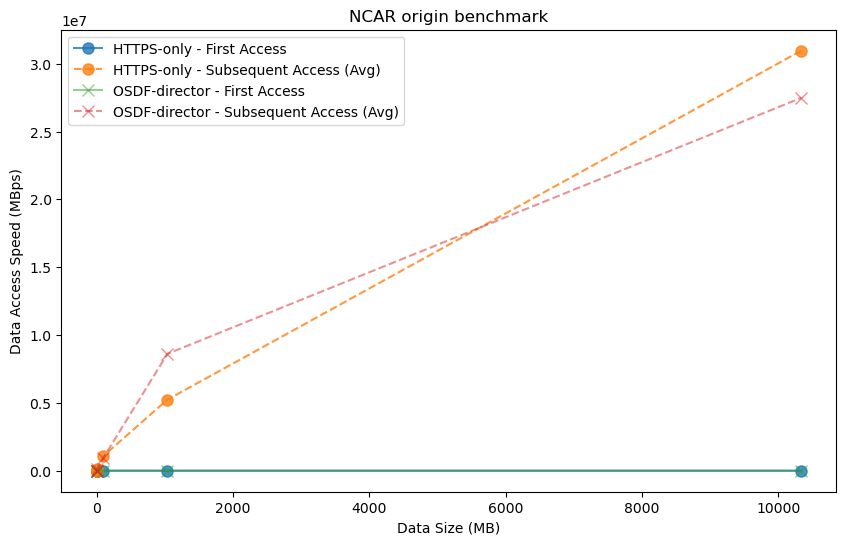

In [62]:
# Plotting MBps vs data size for each protocol and call type
# Define different alpha values for each protocol
alpha_values = {"HTTPS-only": 0.8, "OSDF-director": 0.5}  # Adjust transparency as needed
marker_style = {"HTTPS-only": "o", "OSDF-director": "x"}  # Define different markers for each protocol
#
fig, ax = plt.subplots(figsize=(10, 6))
for protocol in ["HTTPS-only", "OSDF-director"]:
    # First access (call_number == 1)
    first_access = df_diagnostics[(df_diagnostics['protocol'] == protocol) & (df_diagnostics['call_number'] == 1)]
    ax.plot(first_access['dataset_size'], first_access['MBps'], label=f"{protocol} - First Access",
            alpha=alpha_values[protocol],marker=marker_style[protocol],markersize=8)

    # Subsequent access (call_number > 1)
    subsequent_access = df_diagnostics[(df_diagnostics['protocol'] == protocol) & (df_diagnostics['call_number'] > 1)]
    subsequent_access_avg = subsequent_access.groupby('dataset_size')['MBps'].mean()
    ax.plot(subsequent_access_avg.index, subsequent_access_avg.values, 
            linestyle='--', label=f"{protocol} - Subsequent Access (Avg)",alpha=alpha_values[protocol],marker=marker_style[protocol],markersize=8)
    
# Customize plot appearance
ax.set_xlabel("Data Size (MB)")
ax.set_ylabel("Data Access Speed (MBps)")
ax.set_title("NCAR origin benchmark")
ax.legend()
plt.show()


In [23]:
# %%time
# # Number of data access calls
# num_calls = 3  # Modify this as needed

# # DiagnosticTimer class to keep track of runtimes
# class DiagnosticTimer:
#     def __init__(self):
#         self.diagnostics = []

#     @contextmanager
#     def time(self, **kwargs):
#         tic = time.time()
#         yield
#         toc = time.time()
#         kwargs["runtime"] = toc - tic
#         self.diagnostics.append(kwargs)

#     def dataframe(self):
#         return pd.DataFrame(self.diagnostics)

# # Initialize the DiagnosticTimer
# diag_timer = DiagnosticTimer()

# # Benchmarking function to test access speed for each dataset and protocol
# def benchmark_protocol(datasets, protocol_name):
#     # Loop over each dataset in the list (assuming datasets is a list of xarray datasets)
#     for index, dataset in enumerate(datasets):
#         # Each dataset will be loaded multiple times to capture caching effect
#         for call_num in range(num_calls):
#             # Track time for each load operation
#             with diag_timer.time(dataset_size=dataset.nbytes, protocol=protocol_name, call_number=call_num + 1):
#                 # Simulate data access by loading dataset into memory
#                 dataset.load()  # This loads the dataset into memory
#             print(f" Finished processing dataset {index + 1} in {call_num + 1} th call")
#             # time.sleep(1000) # Sleep for some time so that worker memory is cleared


# # Run benchmark for each protocol
# benchmark_protocol(ds_https_list, "HTTPS")
# benchmark_protocol(ds_osdf_list, "OSDF")

 Finished processing dataset 1 in 1 th call
 Finished processing dataset 1 in 2 th call
 Finished processing dataset 1 in 3 th call
 Finished processing dataset 2 in 1 th call
 Finished processing dataset 2 in 2 th call
 Finished processing dataset 2 in 3 th call
 Finished processing dataset 3 in 1 th call
 Finished processing dataset 3 in 2 th call
 Finished processing dataset 3 in 3 th call
 Finished processing dataset 4 in 1 th call
 Finished processing dataset 4 in 2 th call
 Finished processing dataset 4 in 3 th call
 Finished processing dataset 5 in 1 th call
 Finished processing dataset 5 in 2 th call
 Finished processing dataset 5 in 3 th call
 Finished processing dataset 6 in 1 th call
 Finished processing dataset 6 in 2 th call
 Finished processing dataset 6 in 3 th call
 Finished processing dataset 1 in 1 th call
 Finished processing dataset 1 in 2 th call
 Finished processing dataset 1 in 3 th call
 Finished processing dataset 2 in 1 th call
 Finished processing dataset 2 i

In [24]:
# Convert diagnostics to a DataFrame for analysis and plotting
df_diagnostics = diag_timer.dataframe()
df_diagnostics

,dataset_size,protocol,call_number,runtime
0,1040,HTTPS,1,1.977273
1,1040,HTTPS,2,0.000063
2,1040,HTTPS,3,0.000036
3,1327104,HTTPS,1,7.277720
4,1327104,HTTPS,2,0.000060
5,1327104,HTTPS,3,0.000033
6,10616832,HTTPS,1,5.718845
7,10616832,HTTPS,2,0.000070
8,10616832,HTTPS,3,0.000035
9,105283584,HTTPS,1,17.362328


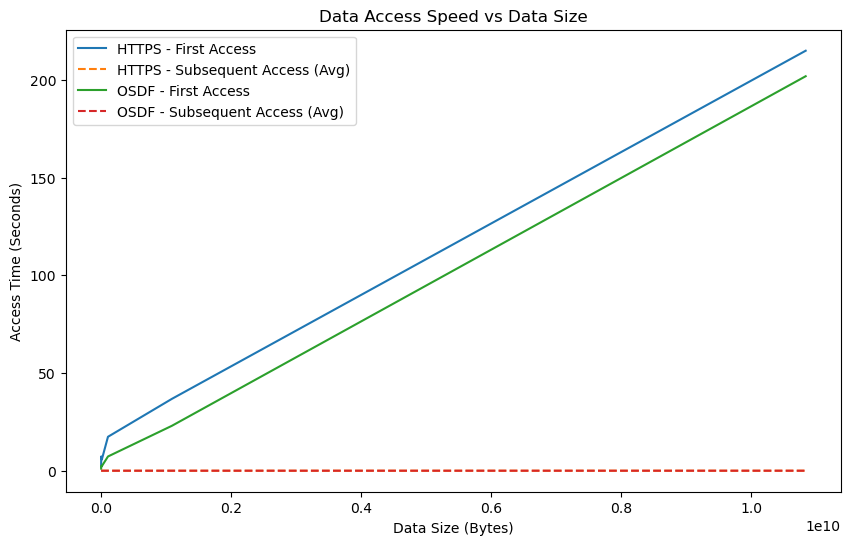

In [26]:
# # Plotting access speed vs data size for each protocol and call type



# fig, ax = plt.subplots(figsize=(10, 6))
# for protocol in ["HTTPS", "OSDF"]:
#     # First access (call_number == 1)
#     first_access = df_diagnostics[(df_diagnostics['protocol'] == protocol) & (df_diagnostics['call_number'] == 1)]
#     ax.plot(first_access['dataset_size'], first_access['runtime'], label=f"{protocol} - First Access")

#     # Subsequent access (call_number > 1)
#     subsequent_access = df_diagnostics[(df_diagnostics['protocol'] == protocol) & (df_diagnostics['call_number'] > 1)]
#     # Get unique dataset sizes and average runtime for subsequent accesses
#     subsequent_access_avg = subsequent_access.groupby('dataset_size')['runtime'].mean()
#     #
#     ax.plot(subsequent_access_avg.index, subsequent_access_avg.values, 
#         linestyle='--', label=f"{protocol} - Subsequent Access (Avg)")

# # Customize plot appearance
# ax.set_xlabel("Data Size (Bytes)")
# ax.set_ylabel("Access Time (Seconds)")
# ax.set_title("Data Access Speed vs Data Size")
# ax.legend()
# plt.show()

In [ ]:
subsequent_access.groupby('dataset_size')['runtime'].mean()

### Try with a specific cache

In [ ]:
historical_smbb_test1 = historical_smbb.isel(time=0).isel(member_id =1+ np.arange(5))
historical_smbb_test1

In [ ]:
%%timeit -r2 -n3 -o
historical_smbb_test1.compute()

In [ ]:
#Try using a specific cache
sdsc_cache='https://sdsc-cache.nationalresearchplatform.org:8443/aws-opendata/us-west-2/ncar-cesm2-lens/atm/monthly/'+\
            'cesm2LE-historical-smbb-TREFHTMX.zarr'

In [ ]:
%%time
test_1 = xr.open_zarr(sdsc_cache).TREFHTMX.isel(time=0)
test_1